In [384]:
pip install scikit-multilearn


Note: you may need to restart the kernel to use updated packages.


In [385]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import LabelEncoder
from skmultilearn.problem_transform import BinaryRelevance,ClassifierChain,LabelPowerset
from skmultilearn.adapt import MLkNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB


In [386]:
df=pd.read_csv("Food_Category.csv")

In [387]:
df.head()

,Unnamed: 0,Item Name,TranslatedIngredients,TotalTimeInMins,Cuisine_x,TranslatedInstructions,URL,Cleaned-Ingredients,image-url,Ingredient-count,Cuisine_y,Course,Nutritional Profile,Preparation Method,Spiciness Level,Vegan/Vegetarian/Contains-Egg/Non-Veg,Allergens,Flavor Profile,Dietary Restrictions
0,0,Masala Karela Recipe,"1 tablespoon Red Chilli powder,3 tablespoon Gr...",45,Indian,"To begin making the Masala Karela Recipe,de-se...",https://www.archanaskitchen.com/masala-karela-...,"salt,amchur (dry mango powder),karela (bitter ...",https://www.archanaskitchen.com/images/archana...,10,Indian,Main,"Low Carb, High Fiber",Stir-Fry,Spicy,Vegetarian,None,"Bitter, Spicy","Diabetic Friendly, Vegan"
1,1,Spicy Tomato Rice (Recipe),"2 teaspoon cashew - or peanuts, 1/2 Teaspoon ...",15,South Indian Recipes,"To make tomato puliogere, first cut the tomato...",https://www.archanaskitchen.com/spicy-tomato-r...,"tomato,salt,chickpea lentils,green chilli,rice...",https://www.archanaskitchen.com/images/archana...,12,Indian,Main,Carbohydrate Rich,"Boiled, Stir-Fried",Spicy,Vegetarian,None,"Spicy, Tangy",Vegan
2,2,Udupi Style Ash Gourd Coconut Curry Recipe,"4 Dry Red Chillies,1/2 teaspoon Turmeric powde...",40,Udupi,To begin making the Udupi Style Ash Gourd Coco...,https://www.archanaskitchen.com/udupi-style-as...,"salt,tamarind water,coconut,mustard seeds,jagg...",https://www.archanaskitchen.com/images/archana...,14,Indian,Main,Vitamin Rich,"Stewed, Curried",Mild,Vegetarian,None,"Creamy, Mild",Vegan
3,3,Mexican Style Black Bean Burrito Recipe,"6 to 8 Spinach Leaves (Palak),1/4 cup Black be...",40,Mexican,"To begin making the Black Bean Burrito recipe,...",https://www.archanaskitchen.com/black-bean-bur...,"tomato,spring onion greens,hung curd (greek yo...",https://www.archanaskitchen.com/images/archana...,12,Mexican,Main,Protein Rich,"Wrapped, Baked",Spicy,Vegetarian,None,"Spicy, Savory",Vegetarian
4,4,Spicy Crunchy Masala Idli Recipe,"Mint Leaves (Pudina) - to taste,1/2 teaspoon T...",30,South Indian Recipes,"To prepare Spicy Crunchy Masala Idli Recipe, H...",https://www.archanaskitchen.com/spicy-crunchy-...,"tomato,salt,coriander (dhania) leaves,idli,red...",https://www.archanaskitchen.com/images/archana...,12,Indian,Breakfast,"Protein Rich, Fermented","Steamed, Stir-Fried",Spicy,Vegetarian,None,"Spicy, Crunchy",None


In [388]:
df.drop('Unnamed: 0',axis=1,inplace=True)

In [389]:
for col in ['Dietary Restrictions','Preparation Method','Flavor Profile','Nutritional Profile']:
    # Iterate over each row in the column
    for index, row in df.iterrows():  # Assuming 'df' is your DataFrame
        # Check if the value is a string
        if isinstance(row[col], str):
            # Split the flavor profile string by commas and convert it into a list
            flavor_profiles_list = row[col].split(', ')
        else:
            # Store as [None] if the value is not a string
            flavor_profiles_list = [None]
        # Update the DataFrame with the list of flavor profiles
        df.at[index, col] = flavor_profiles_list


**Vegan/Vegetarian/Contains-Egg/Non-Veg**

In [390]:
df['Vegan/Vegetarian/Contains-Egg/Non-Veg'].unique()

array(['Vegetarian', 'Non-Veg', 'Vegan', 'Contains Egg', 'Contains-Egg',
       'Contains-Egg, Vegetarian', 'Vegan, Vegetarian',
       'Vegetarian, Vegan', 'Vegetarian, Vegan, Gluten-Free', 'Various',
       'Non-Vegetarian', 'Vegetarian, Contains Dairy',
       'Vegetarian, Contains Dairy, Nuts'], dtype=object)

<Axes: xlabel='Vegan/Vegetarian/Contains-Egg/Non-Veg', ylabel='count'>

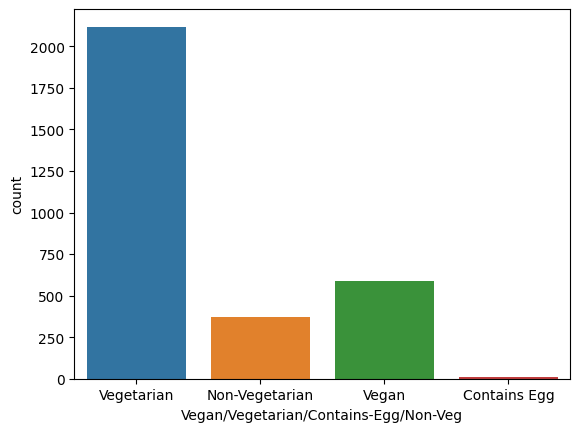

In [391]:
df['Vegan/Vegetarian/Contains-Egg/Non-Veg']=df['Vegan/Vegetarian/Contains-Egg/Non-Veg'].replace({'Non-Veg':'Non-Vegetarian','Contains-Egg':'Contains Egg','Contains-Egg, Vegetarian':'Contains Egg','Vegetarian, Vegan':'Vegetarian','Vegan, Vegetarian':'Vegan','Vegetarian, Vegan, Gluten-Free':'Vegetarian','Vegetarian, Contains Dairy':'Vegetarian','Vegetarian, Contains Dairy, Nuts':'Vegetarian'})
df.drop(df[df['Vegan/Vegetarian/Contains-Egg/Non-Veg']=='Various'].index,inplace=True)
sns.countplot(x='Vegan/Vegetarian/Contains-Egg/Non-Veg',data=df)

In [392]:
df['TranslatedInstructions']=df['TranslatedIngredients'].astype(str)
df['Item Name']=df['Item Name'].astype(str)
df['TranslatedIngredients']=df['TranslatedIngredients'].astype(str)
text_data = df['Item Name']+' '+df['TranslatedIngredients'] + ' ' + df['TranslatedInstructions']


In [393]:
label_encoder1 = LabelEncoder()
y1 = label_encoder1.fit_transform(df['Vegan/Vegetarian/Contains-Egg/Non-Veg'])
X_train, X_test, y_train, y_test = train_test_split(text_data, y1, test_size=0.2, random_state=42)

# Initialize TF-IDF vectorizer
tfidf_vectorizer1 = TfidfVectorizer()
# Fit and transform on training data, transform testing data
X_train_tfidf = tfidf_vectorizer1.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer1.transform(X_test)
model1 = LogisticRegression()
model1.fit(X_train_tfidf, y_train)

#itemname,ingredients,instructions
def Vegan_Vegetarian_ContainEgg_NonVeg():
    
    y_pred = model1.predict(X_test_tfidf)

    # Evaluate model
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    for i in range(1,10):
        itemname=str(df.iloc[i:i+1,0:1].values[0, 0])
        ingredients=str(df.iloc[i:i+1,1:2].values[0, 0])
        instructions=str(df.iloc[i:i+1,2:3].values[0, 0])
        text=[itemname+' '+ingredients+' '+instructions]
        print(text)
        text_transformed=tfidf_vectorizer1.transform(text)
        print("Predicted value ",label_encoder1.inverse_transform(model1.predict(text_transformed)))
        print("Actual value ",df.iloc[i:i+1,14:15].values[0,0])


In [394]:
Vegan_Vegetarian_ContainEgg_NonVeg()

Accuracy: 0.7605177993527508
['Spicy Tomato Rice (Recipe)  2 teaspoon cashew - or peanuts, 1/2 Teaspoon mustard, 1 dry red chilli, 1 teaspoon white urad dal, 1 teaspoon chickpea lentils, salt - as per taste, 1 green chilli, 1-1 / 2 tablespoon oil - 1/2 teaspoon asafoetida, 1/2 teaspoon cumin seeds, 3 teaspoons BC Belle Bhat powder,2-1 / 2 cups rice - cooked, 3 tomatoes 15']
Predicted value  ['Vegetarian']
Actual value  Vegetarian
['Udupi Style Ash Gourd Coconut Curry Recipe 4 Dry Red Chillies,1/2 teaspoon Turmeric powder (Haldi),1/2 teaspoon Mustard seeds,1 Dry Red Chillies,Sunflower Oil - for cooking,Salt - to taste,30 grams Tamarind Water,1 cup Tamarind Water,1/2 cup Fresh coconut - grated,2 sprig Curry leaves - roughly torn,500 grams Vellai Poosanikai (Ash gourd/White Pumpkin),1/2 teaspoon Methi Seeds (Fenugreek Seeds),2 teaspoons Sesame seeds (Til seeds),1 teaspoon Sunflower Oil,3 tablespoons Jaggery,2 teaspoons Coriander (Dhania) Seeds,1/2 teaspoon Cumin seeds (Jeera) 40']
Predict

**Cuisine**

In [395]:
df['Cuisine_x'].unique()

array(['Indian', 'South Indian Recipes', 'Udupi', 'Mexican',
       'Continental', 'Punjabi', 'Fusion', 'North Indian Recipes',
       'Italian Recipes', 'Thai', 'Chinese', 'Kerala Recipes',
       'Gujarati Recipes\ufeff', 'Chettinad', 'Tamil Nadu', 'Coorg',
       'Andhra', 'Rajasthani', 'Bengali Recipes', 'Asian',
       'Middle Eastern', 'Maharashtrian Recipes', 'Coastal Karnataka',
       'Kashmiri', 'Karnataka', 'Lucknowi', 'Hyderabadi', 'Side Dish',
       'Goan Recipes', 'Arab', 'Assamese', 'Bihari', 'Malabar',
       'Himachal', 'Awadhi', 'Cantonese', 'North East India Recipes',
       'Sichuan', 'Mughlai', 'Japanese', 'Sindhi', 'Mangalorean',
       'Vietnamese', 'British', 'North Karnataka', 'Parsi Recipes',
       'Greek', 'Nepalese', 'Oriya Recipes', 'French', 'Indo Chinese',
       'Konkan', 'Mediterranean', 'Sri Lankan', 'European',
       'Uttar Pradesh', 'Malvani', 'Indonesian', 'African', 'Korean',
       'American', 'Kongunadu', 'Caribbean', 'South Karnataka',
      

In [396]:
North_indian=['Gujarati','Rajasthani','Punjabi','Bengali','Maharashtrian','Uttarakhand-North Kumaon','Malvani','Haryana','Assamese','Uttar Pradesh','North Indian Recipes','Kashmiri','Sindhi','Oriya Recipes','Mughlai','Hyderabadi','Awadhi','Himachal','Bihari','North East India Recipes','Lucknowi']
South_indian=['Andhra','Chettinad','Kerala','Kongunadu','Tamil Nadu','South Indian Recipes','Udupi','Malabar','Coorg','Mangalorean','Karnataka','Coastal Karnataka','North Karnataka','South Karnataka']
Indian=['Indian','Konkan','Mughlai','Kashmiri','Goan Recipes']
International = [
    'World Breakfast',
    'American',
    'Afghan',
    'Arab',
    'Cantonese',
    'Sichuan',
    'Indonesian',
    'Malaysian',
    'British',
    'Appetizer',
    'Korean',
    'Caribbean',
    'Dessert',
    'Hunan',
    'Dinner',
    'Snack',
    'Jewish',
    'Burmese',
    'Side Dish',
    'French',
    'Indo Chinese',
    'Parsi Recipes',
    'Mediterranean',
    'European',
    'Greek',
    'Sri Lankan',
    'African',
    'Japanese',
    'Pakistani',
    'Vietnamese',
    'Nepalese',
    'Fusion',
    'Mexican'
    'Asian',
    'Chinese',
    'Thai',
    'Middle Eastern'
]


In [397]:
df['Cuisine_x']=df['Cuisine_x'].replace({'Gujarati Recipes\ufeff':'Gujarati','Italian Recipes':'Italian','Maharashtrian Recipes':'Maharashtrian','Bengali Recipes':'Bengali','Kerala Recipes':'Kerala','Gujarati Recipes':'Gujarati'})
for i in International:
  df['Cuisine_x']=df['Cuisine_x'].replace({i:'International'})
for i in Indian:
  df['Cuisine_x']=df['Cuisine_x'].replace({i:'Indian'})
for i in North_indian:
  df['Cuisine_x']=df['Cuisine_x'].replace({i:'North Indian'})
for i in South_indian:
  df['Cuisine_x']=df['Cuisine_x'].replace({i:'South Indian'})


In [398]:
df['Cuisine_x'].value_counts()

North Indian     832
South Indian     639
Indian           573
Continental      498
International    320
Italian          124
Mexican           65
Asian             37
Name: Cuisine_x, dtype: int64

In [399]:
label_encoder2 = LabelEncoder()
y2 = label_encoder2.fit_transform(df['Cuisine_x'])
X_train, X_test, y_train, y_test = train_test_split(text_data, y2, test_size=0.2, random_state=42)

# Initialize TF-IDF vectorizer
tfidf_vectorizer2 = TfidfVectorizer()

# Fit and transform on training data, transform testing data
X_train_tfidf = tfidf_vectorizer2.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer2.transform(X_test)
model2 = LogisticRegression()
model2.fit(X_train_tfidf, y_train)

#itemname,ingredients,instructions
def Cuisine():
    
    y_pred = model2.predict(X_test_tfidf)

    # Evaluate model
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    for i in range(1,10):
        itemname=str(df.iloc[i:i+1,0:1].values[0, 0])
        ingredients=str(df.iloc[i:i+1,1:2].values[0, 0])
        instructions=str(df.iloc[i:i+1,2:3].values[0, 0])
        text=[itemname+' '+ingredients+' '+instructions]
        print(text)
        text_transformed=tfidf_vectorizer2.transform(text)
        print("Predicted value ",label_encoder2.inverse_transform(model2.predict(text_transformed)))
        print("Actual value ",df.iloc[i:i+1,3:4].values[0,0])


In [400]:
Cuisine()

Accuracy: 0.6359223300970874
['Spicy Tomato Rice (Recipe)  2 teaspoon cashew - or peanuts, 1/2 Teaspoon mustard, 1 dry red chilli, 1 teaspoon white urad dal, 1 teaspoon chickpea lentils, salt - as per taste, 1 green chilli, 1-1 / 2 tablespoon oil - 1/2 teaspoon asafoetida, 1/2 teaspoon cumin seeds, 3 teaspoons BC Belle Bhat powder,2-1 / 2 cups rice - cooked, 3 tomatoes 15']
Predicted value  ['South Indian']
Actual value  South Indian
['Udupi Style Ash Gourd Coconut Curry Recipe 4 Dry Red Chillies,1/2 teaspoon Turmeric powder (Haldi),1/2 teaspoon Mustard seeds,1 Dry Red Chillies,Sunflower Oil - for cooking,Salt - to taste,30 grams Tamarind Water,1 cup Tamarind Water,1/2 cup Fresh coconut - grated,2 sprig Curry leaves - roughly torn,500 grams Vellai Poosanikai (Ash gourd/White Pumpkin),1/2 teaspoon Methi Seeds (Fenugreek Seeds),2 teaspoons Sesame seeds (Til seeds),1 teaspoon Sunflower Oil,3 tablespoons Jaggery,2 teaspoons Coriander (Dhania) Seeds,1/2 teaspoon Cumin seeds (Jeera) 40']
Pre

**Course**

In [401]:
df['Course'].unique()

array(['Main', 'Breakfast', 'Side', 'Appetizer', 'Dessert', 'Salad',
       'Bread', 'Snack', 'Soup', 'Beverage', 'Spice', 'Sauce',
       'Condiment', 'Side Dish', 'Main Dish', 'Sandwich', 'Dip',
       'Main Course', 'Base', 'Snack/Dessert', 'Dessert/Snack',
       'Dip/Snack', 'Snack/Lunch', 'Snack/Breakfast', 'Spice Mix'],
      dtype=object)

In [402]:
df['Course'].value_counts()

Main Dish          637
Main               420
Dessert            398
Snack              326
Main Course        276
Side Dish          206
Breakfast          202
Appetizer          126
Salad               93
Condiment           81
Soup                79
Side                78
Beverage            76
Bread               57
Sauce                8
Dip                  5
Spice                4
Sandwich             3
Dip/Snack            3
Snack/Dessert        2
Dessert/Snack        2
Snack/Breakfast      2
Spice Mix            2
Base                 1
Snack/Lunch          1
Name: Course, dtype: int64

In [403]:
Main=['Main Dish','Main']
Side=['Side Dish','Side']
Condiment=['Condiment','Sauce','Dip','Spice','Dip/Snack','Spice Mix','Base']
Snack=['Snack','Snack/Lunch','Dessert/Snack','Snack/Dessert','Sandwich','Snack/Breakfast']
Appetizer=['Appetizer','Soup']

In [404]:
categories = {
    'Main': Main,
    'Side': Side,
    'Condiment': Condiment,
    'Snack': Snack,
    'Appetizer':Appetizer
}

# Perform replacements
for category, items in categories.items():
    for item in items:
        df['Course'] = df['Course'].replace({item: category})

In [405]:
df['Course'].value_counts()

Main           1057
Dessert         398
Snack           336
Side            284
Main Course     276
Appetizer       205
Breakfast       202
Condiment       104
Salad            93
Beverage         76
Bread            57
Name: Course, dtype: int64

In [406]:
label_encoder3 = LabelEncoder()
y3 = label_encoder3.fit_transform(df['Course'])
X_train, X_test, y_train, y_test = train_test_split(text_data, y3, test_size=0.2, random_state=42)

# Initialize TF-IDF vectorizer
tfidf_vectorizer3 = TfidfVectorizer()

# Fit and transform on training data, transform testing data
X_train_tfidf = tfidf_vectorizer3.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer3.transform(X_test)
model3 = LogisticRegression()
model3.fit(X_train_tfidf, y_train)
#itemname,ingredients,instructions

def Course():
    y_pred = model3.predict(X_test_tfidf)

    # Evaluate model
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    for i in range(1,10):
        itemname=str(df.iloc[i:i+1,0:1].values[0, 0])
        ingredients=str(df.iloc[i:i+1,1:2].values[0, 0])
        instructions=str(df.iloc[i:i+1,2:3].values[0, 0])
        text=[itemname+' '+ingredients+' '+instructions]
        print(text)
        text_transformed=tfidf_vectorizer3.transform(text)
        print("Predicted value ",label_encoder3.inverse_transform(model3.predict(text_transformed)))
        print("Actual value ",df.iloc[i:i+1,10:11].values[0,0])


In [407]:
Course()

Accuracy: 0.5663430420711975
['Spicy Tomato Rice (Recipe)  2 teaspoon cashew - or peanuts, 1/2 Teaspoon mustard, 1 dry red chilli, 1 teaspoon white urad dal, 1 teaspoon chickpea lentils, salt - as per taste, 1 green chilli, 1-1 / 2 tablespoon oil - 1/2 teaspoon asafoetida, 1/2 teaspoon cumin seeds, 3 teaspoons BC Belle Bhat powder,2-1 / 2 cups rice - cooked, 3 tomatoes 15']
Predicted value  ['Main']
Actual value  Main
['Udupi Style Ash Gourd Coconut Curry Recipe 4 Dry Red Chillies,1/2 teaspoon Turmeric powder (Haldi),1/2 teaspoon Mustard seeds,1 Dry Red Chillies,Sunflower Oil - for cooking,Salt - to taste,30 grams Tamarind Water,1 cup Tamarind Water,1/2 cup Fresh coconut - grated,2 sprig Curry leaves - roughly torn,500 grams Vellai Poosanikai (Ash gourd/White Pumpkin),1/2 teaspoon Methi Seeds (Fenugreek Seeds),2 teaspoons Sesame seeds (Til seeds),1 teaspoon Sunflower Oil,3 tablespoons Jaggery,2 teaspoons Coriander (Dhania) Seeds,1/2 teaspoon Cumin seeds (Jeera) 40']
Predicted value  ['

**Flavor Profile**

In [408]:
df_exploded = df.explode('Flavor Profile')
value_counts = df_exploded['Flavor Profile'].value_counts()
categories_less_than_30 = []+['Healthy','Flavorful','Aromatic','Comforting','Refreshing','Soft','Mild','Coconutty','Regional','Cheesy','Refreshing','Fruity','Rich','Chocolatey','Fresh']
for category, count in value_counts.items():
    if count < 30:
        categories_less_than_30.append(category)
        categories_less_than_30.append(' '+category)

print("Categories with counts less than 30:", len(categories_less_than_30))


Categories with counts less than 30: 333


In [409]:
# Iterate over each row in the 'Flavor Profile' column
for index, row in df.iterrows():
    if 'Protein Rich' in row['Flavor Profile']:
        # Remove 'Protein Rich' from the list and append 'Protein-Rich'
        row['Flavor Profile'].remove('Protein Rich')
        row['Flavor Profile'].append('Protein-rich')
    if 'Spiced' in row['Flavor Profile']:
        # Remove 'Protein Rich' from the list and append 'Protein-Rich'
        row['Flavor Profile'].remove('Spiced')
        row['Flavor Profile'].append('Spicy')
    # Check if the row contains any of the items to remove
    for item in categories_less_than_30:
        if item in row['Flavor Profile']:
            # Remove the item from the list
            row['Flavor Profile'].remove(item)


In [410]:
df_exploded = df.explode('Flavor Profile')

# Calculate value counts for each category
value_counts = df_exploded['Flavor Profile'].value_counts()
value_counts

Spicy            1378
Sweet             488
Tangy             473
Savory            347
Creamy            308
Nutty             243
Crunchy           136
Crispy            106
Protein-rich      104
Nutrient-rich      81
Name: Flavor Profile, dtype: int64

In [411]:
y4=df[['Flavor Profile']]
unique_categories = ['Spicy', 'Sweet', 'Tangy', 'Savory', 'Creamy', 'Nutty', 'Crunchy', 'Crispy', 'Protein-rich', 'Nutrient-rich']
for category in unique_categories:
    y4[category] = y4['Flavor Profile'].apply(lambda x: 1 if category in x else 0)
y4.drop('Flavor Profile',axis=1,inplace=True)
y4.head()
tfidf_vectorizer4 = TfidfVectorizer()
X=tfidf_vectorizer4.fit_transform(text_data).toarray()
X_train, X_test, y_train, y_test = train_test_split(X, y4, test_size=0.2, random_state=42)
LabelPowerset_clf1=LabelPowerset(MultinomialNB())
LabelPowerset_clf1.fit(X_train,y_train)

/var/folders/n5/vm862s_n5p751f9xypymdzw40000gn/T/ipykernel_83841/1424316355.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y4[category] = y4['Flavor Profile'].apply(lambda x: 1 if category in x else 0)
/var/folders/n5/vm862s_n5p751f9xypymdzw40000gn/T/ipykernel_83841/1424316355.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y4[category] = y4['Flavor Profile'].apply(lambda x: 1 if category in x else 0)
/var/folders/n5/vm862s_n5p751f9xypymdzw40000gn/T/ipykernel_83841/1424316355.py:4: SettingWithCopyW

LabelPowerset(classifier=MultinomialNB(), require_dense=[True, True])

In [412]:
def FlavorProfile():
    br_prediction = LabelPowerset_clf1.predict(X_test)
    print("Accuracy ",accuracy_score(y_test,br_prediction))
    for i in range(1,3000):
        itemname = str(df.iloc[i:i+1, 0:1].values[0, 0])
        ingredients = str(df.iloc[i:i+1, 1:2].values[0, 0])
        instructions = str(df.iloc[i:i+1, 2:3].values[0, 0])
        text = [itemname + ' ' + ingredients + ' ' + instructions]
        text_transformed = tfidf_vectorizer4.transform(text).toarray()
        temp=LabelPowerset_clf1.predict(text_transformed).toarray()

        # Define the unique categories
        unique_categories = ['Spicy', 'Sweet', 'Tangy', 'Savory', 'Creamy', 'Nutty', 'Crunchy', 'Crispy', 'Protein-rich', 'Nutrient-rich']

        # Create an empty list to store the decoded categories
        decoded_categories = []

        # Iterate over each category and its corresponding predicted value
        for category, value in zip(unique_categories, temp[0]):
            if value == 1:
                decoded_categories.append(category)
        if ('Sweet' in decoded_categories):
            print(text)
            print("Predicted value:", decoded_categories)
            print("Actual value ", df.iloc[i:i+1, 16:17].values[0, 0])



In [413]:
FlavorProfile()

Accuracy  0.2815533980582524
['Eggless Chocolate Cupcakes With Raspberry & Cheese Frosting 1/2 tablespoon Baking powder,8 Fresh raspberries,1 cup All Purpose Flour (Maida),1 cup Britannia Cream Cheese,3/4 cup Caster Sugar,1/2 tablespoon Vanilla Extract,1/2 cup Cocoa Powder,1 cup Dark chocolate,1/2 cup Salted butter,1 teaspoon Vanilla Extract,3/4 cup Milk,1/2 teaspoon Baking soda,1/2 cup Sugar 40']
Predicted value: ['Sweet']
Actual value  ['Sweet']
['Kerala pala pradham recipe 3/4 cup Sugar,2 liter Milk - full cream,1 cup Ada,1/2 teaspoon Cardamom Powder (Elaichi),1 tablespoon Ghee 90']
Predicted value: ['Sweet']
Actual value  ['Sweet', 'Creamy']
['Mango Donut Cake Recipe With Chocolate Glaze 3 Sugar - powdered,1-1/2 teaspoons Baking powder,1-1/2 cups Vivatta Maida,1/4 teaspoon Salt,1 teaspoon Vanilla Extract,1/4 cup Fresh cream,1/4 cup Sugar,1/4 cup Sunflower Oil,3/4 cup Mango Pulp (Puree),2 tablespoons Cocoa Powder,1/4 teaspoon Baking soda,150 grams Dark chocolate - chopped 51']
Predi

**Preparation Method**

In [414]:
df_exploded = df.explode('Preparation Method')

value_counts = df_exploded['Preparation Method'].value_counts()
print(value_counts)

Cooked                                               998
Baked                                                310
Mixed                                                175
Fried                                                163
Assembled                                            126
                                                    ... 
and Cheese Filling                                     1
Stir-fried Green Beans and Moth Beans Sabzi            1
Stir-fried Yam (Chena) with Coconut                    1
Appam made with Ragi Flour                             1
Garlic-flavored potato curry with Gujarati spices      1
Name: Preparation Method, Length: 1028, dtype: int64


In [415]:
df_exploded = df.explode('Preparation Method')

value_counts = df_exploded['Preparation Method'].value_counts()

# Initialize a list to store categories with counts less than 30
categories_less_than_30 = []+['Prepared','Cooked']
# Iterate over the value counts
for category, count in value_counts.items():
    if count < 20:
        categories_less_than_30.append(category)
print("Categories with counts less than 20:", len(categories_less_than_30))


Categories with counts less than 20: 1012


In [416]:
# Iterate over each row in the 'Preparation Method' column
for index, row in df.iterrows():
    if 'Pan-Fried' in row['Preparation Method']:
        # Remove 'Pan-Fried' from the list and append 'Pan-fried'
        row['Preparation Method'].remove('Pan-Fried')
        row['Preparation Method'].append('Pan-fried')
    if 'Deep-Fried' in row['Preparation Method']:
        # Remove 'Deep-Fried' from the list and append 'Deep-fried'
        row['Preparation Method'].remove('Deep-Fried')
        row['Preparation Method'].append('Deep-fried')
    if 'Stir-Fried' in row['Preparation Method']:
        # Remove 'Stir-Fried' from the list and append 'Stir-fried'
        row['Preparation Method'].remove('Stir-Fried')
        row['Preparation Method'].append('Stir-fried')
    if 'Fried' in row['Preparation Method']:
        # Remove 'Stir-Fried' from the list and append 'Stir-fried'
        row['Preparation Method'].remove('Fried')
        row['Preparation Method'].append('Deep-fried')
    # Check if the row contains any of the items to remove
    for item in categories_less_than_30:
        if item in row['Preparation Method']:
            # Remove the item from the list
            row['Preparation Method'].remove(item)


In [417]:
df_exploded = df.explode('Preparation Method')

value_counts = df_exploded['Preparation Method'].value_counts()
print(value_counts)

Baked        310
Mixed        175
Assembled    126
Boiled        88
Blended       69
Grilled       66
Steamed       62
Curried       57
Simmered      42
Pan-fried     40
Stewed        39
Roasted       28
Stuffed       24
Name: Preparation Method, dtype: int64


In [418]:
y5=df[['Preparation Method']]
# Define the unique categories
unique_categories = [
    'Baked',
    'Deep-fried',
    'Mixed',
    'Stir-fried',
    'Assembled',
    'Boiled',
    'Blended',
    'Grilled',
    'Steamed',
    'Curried',
    'Simmered',
    'Pan-fried',
    'Stewed',
    'Roasted',
    'Stuffed'
]

# Iterate over each unique category
for category in unique_categories:
    # Create a new column for the category
    y5[category] = y5['Preparation Method'].apply(lambda x: 1 if category in x else 0)

# Print the updated DataFrame
print(y5.head())
y5.drop('Preparation Method',axis=1,inplace=True)
# Assuming df is your DataFrame containing the one-hot encoded data
y5 = y5.astype(float)

  Preparation Method  Baked  Deep-fried  Mixed  Stir-fried  Assembled  Boiled  \
0                 []      0           0      0           0          0       0   
1           [Boiled]      0           0      0           0          0       1   
2  [Stewed, Curried]      0           0      0           0          0       0   
3            [Baked]      1           0      0           0          0       0   
4          [Steamed]      0           0      0           0          0       0   

   Blended  Grilled  Steamed  Curried  Simmered  Pan-fried  Stewed  Roasted  \
0        0        0        0        0         0          0       0        0   
1        0        0        0        0         0          0       0        0   
2        0        0        0        1         0          0       1        0   
3        0        0        0        0         0          0       0        0   
4        0        0        1        0         0          0       0        0   

   Stuffed  
0        0  
1        0  

/var/folders/n5/vm862s_n5p751f9xypymdzw40000gn/T/ipykernel_83841/1387602987.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y5[category] = y5['Preparation Method'].apply(lambda x: 1 if category in x else 0)
/var/folders/n5/vm862s_n5p751f9xypymdzw40000gn/T/ipykernel_83841/1387602987.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y5[category] = y5['Preparation Method'].apply(lambda x: 1 if category in x else 0)
/var/folders/n5/vm862s_n5p751f9xypymdzw40000gn/T/ipykernel_83841/1387602987.py:24: Setti

In [419]:
X_train, X_test, y_train, y_test = train_test_split(X, y5, test_size=0.2, random_state=42)

tfidf_vectorizer5 = TfidfVectorizer()
X=tfidf_vectorizer5.fit_transform(text_data).toarray()
LabelPowerset_clf2=LabelPowerset(MultinomialNB())
LabelPowerset_clf2.fit(X_train,y_train)

LabelPowerset(classifier=MultinomialNB(), require_dense=[True, True])

In [420]:
def prep_method():
    br_prediction = LabelPowerset_clf2.predict(X_test)
    print(accuracy_score(y_test,br_prediction))
    for i in range(1, 3000):
        itemname = str(df.iloc[i:i+1, 0:1].values[0, 0])
        ingredients = str(df.iloc[i:i+1, 1:2].values[0, 0])
        instructions = str(df.iloc[i:i+1, 2:3].values[0, 0])
        text = [itemname + ' ' + ingredients + ' ' + instructions]
        text_transformed = tfidf_vectorizer5.transform(text).toarray()
        temp=LabelPowerset_clf2.predict(text_transformed).toarray()

        # Define the unique categories
        unique_categories = [
        'Baked',
        'Deep-fried',
        'Mixed',
        'Stir-fried',
        'Assembled',
        'Boiled',
        'Blended',
        'Grilled',
        'Steamed',
        'Curried',
        'Simmered',
        'Pan-fried',
        'Stewed',
        'Roasted',
        'Stuffed'
    ]

        # Create an empty list to store the decoded categories
        decoded_categories = []

        # Iterate over each category and its corresponding predicted value
        for category, value in zip(unique_categories, temp[0]):
            if value == 1:
                decoded_categories.append(category)
        if len(decoded_categories)!=0:
            # Print the decoded categories
            print(text)
            print("Predicted value:", decoded_categories)
            print("Actual value ", df.iloc[i:i+1, 12:13].values[0, 0])


In [421]:
prep_method()

0.6359223300970874
['Eggless Chocolate Cupcakes With Raspberry & Cheese Frosting 1/2 tablespoon Baking powder,8 Fresh raspberries,1 cup All Purpose Flour (Maida),1 cup Britannia Cream Cheese,3/4 cup Caster Sugar,1/2 tablespoon Vanilla Extract,1/2 cup Cocoa Powder,1 cup Dark chocolate,1/2 cup Salted butter,1 teaspoon Vanilla Extract,3/4 cup Milk,1/2 teaspoon Baking soda,1/2 cup Sugar 40']
Predicted value: ['Baked']
Actual value  ['Baked']
["Eggless Devil's Food Cake Recipe 2 cups All Purpose Flour (Maida),Chocolate ganache - as needed,2/3 cup Cocoa Powder,1-1/2 teaspoons Baking powder,3 Whole Eggs - or Flaxmeal Egg Replacer,3 tablespoons Flax seed powder (flax meal),1/4 teaspoon Salt,1/2 teaspoon Red Food Color - (only optional),3/4 cup Curd (Dahi / Yogurt),9 tablespoons Chilled water,1-1/2 teaspoon Vanilla Extract,3/4 cup Butter - softened,1-1/2 cups Caster Sugar 110"]
Predicted value: ['Baked']
Actual value  ['Baked']
['Moon Biscuits Recipe (Moon Shaped Baked Cookies) 175 grams Butter

**Prediction**

In [422]:
import requests
from bs4 import BeautifulSoup

In [423]:
def predict(text):
    text_transformed=tfidf_vectorizer1.transform(text)
    print(label_encoder1.inverse_transform(model1.predict(text_transformed)))
    text_transformed=tfidf_vectorizer2.transform(text)
    print(label_encoder2.inverse_transform(model2.predict(text_transformed)))
    text_transformed=tfidf_vectorizer3.transform(text)
    print(label_encoder3.inverse_transform(model3.predict(text_transformed)))
    
    text_transformed = tfidf_vectorizer4.transform(text).toarray()
    temp=LabelPowerset_clf1.predict(text_transformed).toarray()
    unique_categories = ['Spicy', 'Sweet', 'Tangy', 'Savory', 'Creamy', 'Nutty', 'Crunchy', 'Crispy', 'Protein-rich', 'Nutrient-rich']
    decoded_categories = []
    for category, value in zip(unique_categories, temp[0]):
        if value == 1:
            decoded_categories.append(category)
    
    print(decoded_categories)
    text_transformed = tfidf_vectorizer5.transform(text).toarray()
    temp=LabelPowerset_clf2.predict(text_transformed).toarray()
    unique_categories = [
    'Baked',
    'Deep-fried',
    'Mixed',
    'Stir-fried',
    'Assembled',
    'Boiled',
    'Blended',
    'Grilled',
    'Steamed',
    'Curried',
    'Simmered',
    'Pan-fried',
    'Stewed',
    'Roasted',
    'Stuffed'
]
    decoded_categories = []
    for category, value in zip(unique_categories, temp[0]):
        if value == 1:
            decoded_categories.append(category)
    print(decoded_categories)


**Scraping details from Tarla Dalal and predicting the tags**

In [450]:
food=input("Enter the name of the food:")
food='+'.join(food.split(' '))
url='https://www.tarladalal.com/RecipeSearch.aspx?rec=1&term='+food
response = requests.get(url)
if response.status_code == 200:
    # Parse the HTML content of the webpage
    soup = BeautifulSoup(response.text, 'html.parser')
    elements = soup.find(class_='rcc_recipename')

elements = soup.find(class_='rcc_recipename')
if (elements!=None):
    recipe_id = elements.find('a')['href']
    recipe_link='https://www.tarladalal.com/'+recipe_id
    print("Recipe link ",recipe_link)
    response = requests.get(recipe_link)
    if response.status_code == 200:
        # Parse the HTML content of the webpage
        soup = BeautifulSoup(response.text, 'html.parser')
    elements = soup.find(id='rcpinglist')
    if (elements.find('span', {'id': 'ingsection1'})!=None):
        elements = elements.find('span', {'id': 'ingsection1'})
    ingredients = elements.find_all_next('span', {'itemprop': 'recipeIngredient'})


    # Extract ingredient text
    ingredient_list = []
    for ingredient in ingredients:
        # Check if the ingredient is still under ingsection1
        if ingredient.find_previous_sibling('span', {'id': 'ingsection2'}):
            break
        ingredient_text = ingredient.get_text(strip=True)
        ingredient_list.append(ingredient_text)

    # Print the ingredients under ingsection1
    for ingredient in ingredient_list:
        print("Ingredients \n",ingredient)
    response = requests.get(recipe_link)
    if response.status_code == 200:
        # Parse the HTML content of the webpage
        soup = BeautifulSoup(response.text, 'html.parser')
    section = soup.find(id='ctl00_cntrightpanel_pnlRcpMethod')
    instruct=''
    # Find all the steps under the specified section
    if section:
        steps = section.find_next('ol', {'class': 'rcpprocsteps'})
        if steps:
            step_items = steps.find_all('li')
            for step in step_items:
                step_text = step.find('span', {'itemprop': 'text'})
                if step_text:
                    instruct+=step_text.text.strip()+'\n'
    print("instructions\n",instruct)
    textdata=[food+' '+ingredient+' '+instruct]

else:
    print("Recipe not found")
    textdata=[food]
predict(textdata)


Recipe link  https://www.tarladalal.com/biscuity-nutty-and-chocolaty-balls-39460r
Ingredients 
 10marie biscuits
Ingredients 
 5dark chocolate biscuits
Ingredients 
 5 tbspnutella hazelnut chocolate spread
Ingredients 
 2 tbspchopped mixed nuts(almonds , pistachio and walnuts)
instructions
 Open each dark chocolate biscuit and scrape and discard the middle creamy layer.
Crush the cream biscuits and marie biscuits on a butter paper or a rolling board into a coarse powder with the help of a rolling pin.
Transfer the crushed biscuits in a deep bowl, add all the remaining ingredients mix well and refrigerate for 30 minutes.
Divide the mixture into 15 equal portions and roll each portion into a round ball.
Refrigerate for at least 1 hour.
Serve chilled.

['Vegetarian']
['Continental']
['Dessert']
['Sweet']
[]


**Scraping details from Indian Healthy websites and predicting the tags**

In [451]:
# Send an HTTP GET request to the website
food=input("Enter the name of the food:")
food='+'.join(food.split(' '))
url = 'https://www.indianhealthyrecipes.com/?s='+food
response = requests.get(url)
print(url)
# Find all elements with the class name 'kb-section-link-overlay' (each category links)
elements = []
if response.status_code == 200:
    # Parse the HTML content of the webpage
    soup = BeautifulSoup(response.text, 'html.parser')
    # Find all elements with the class name 'kb-section-link-overlay'
    elements = soup.find(class_='post-thumbnail kadence-thumbnail-ratio-2-3').get('href')
    print(1,elements)
url=elements
response = requests.get(url)
print("Extracted href:", url)
print(response)
elements = []
if response.status_code == 200:
    # Parse the HTML content of the webpage
    soup = BeautifulSoup(response.text, 'html.parser')
    # Find all elements with the class name 'kb-section-link-overlay'
    elements = soup.find_all(class_='wprm-recipe-ingredient-name')
    ingredients = [span.get_text(strip=True) for span in elements]
    ingred=''
    # Print the extracted ingredients
    for ingredient in ingredients:
        ingred+=ingredient+' '
    print(ingred)
    instruct=''
    elements = soup.find_all(class_='wprm-recipe-instruction-text')
    instructions = [span.get_text(strip=True) for span in elements]
    # Print the extracted ingredients
    for inst in instructions:
        instruct+=inst+' '
    print(instruct)
    textdata=[food+' '+ingred+' '+instruct]
    predict(textdata)

https://www.indianhealthyrecipes.com/?s=chicken+biriyani
1 https://www.indianhealthyrecipes.com/butter-chicken/
Extracted href: https://www.indianhealthyrecipes.com/butter-chicken/
<Response [200]>
boneless chicken Kashmiri red chili powder salt lemon juice Greek yogurt ginger garlic paste turmeric garam masala cumin powder coriander powder kasuri methi oil butter cinnamon green cardamoms cloves onions fresh tomato puree ginger garlic paste green chilies whole raw cashews water Kashmiri chili powder garam masala coriander powder cumin powder salt sugar Kasuri methi hot water heavy cream coriander leaves 
Marinate chicken with lemon juice, chili powder and salt. Cover and rest for 20 minutes. Next add yogurt, kasuri methi, oil, turmeric, ginger garlic paste, coriander powder, cumin powder and garam masala powder. Marinate and rest for a minimum of 30 minutes, or overnight for best results. Cover and refrigerate. Optional – If using onion, sauté in 1 tablespoon oil until lightly golden, 

**We can scrape multiple websites to retrieve the ingredients and use cosine similarity to find the most reliable recipe and use it for predicting**